In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency #scientific python
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pip install haversine

In [ ]:
from haversine import haversine, Unit


In [ ]:
def findDistance(lat1, long1, lat2, long2):
    point1 = (lat1, long1)
    point2 = (lat2, long2)

    distance_miles = haversine(point1, point2, unit=Unit.MILES)
    #print(f"Distance: {distance_km:.2f} miles")
    return distance_miles


In [ ]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    return R * c

In [ ]:


  # latitude1 = 40.580638
  # longitude1 =
  # latitude2 = 40.594286
  # longitude2 =
  df = pd.DataFrame({
    "pickup_latitude": [40.690045],
    "pickup_longitude":   [-73.788101],
    "dropoff_latitude": [40.594286],
    "dropoff_longitude": [-73.780625]
})

  # point1 = (latitude1, longitude1)
  # point2 = (latitude2, longitude2)

  distance_km = haversine(df['pickup_latitude'], df['pickup_longitude'],df['dropoff_latitude'], df['dropoff_longitude'])
  print(f"Distance: {distance_km:.2f} miles")

Distance: 10.67 miles


In [ ]:
#Reading data
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [ ]:
#size of the train data
#keep a copy of train
train_copy = train.copy()
test_copy = test.copy()
train.shape

(14699, 14)

In [ ]:
train.shape

(14699, 14)

In [ ]:
test.shape

(300, 14)

In [ ]:
#Finding null values in train
for col in train.columns:
  print(col, train[col].isna().sum())

pickup_datetime 0
dropoff_datetime 0
pickup_latitude 0
pickup_longitude 0
dropoff_latitude 0
dropoff_longitude 0
passenger_count 0
traffic_congestion_level 0
pickup_borough 0
dropoff_borough 0
tolls_amount 0
tip_amount 0
fare_estimate 0
trip_distance_miles 0


In [ ]:
train.loc[train['dropoff_longitude']>0]

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,traffic_congestion_level,pickup_borough,dropoff_borough,tolls_amount,tip_amount,fare_estimate,trip_distance_miles


In [ ]:
#finding null values in test
for col in test.columns:
  print(col, test[col].isna().sum())

pickup_datetime 0
dropoff_datetime 0
pickup_latitude 0
pickup_longitude 0
dropoff_latitude 0
dropoff_longitude 0
passenger_count 0
traffic_congestion_level 0
pickup_borough 0
dropoff_borough 0
tolls_amount 0
tip_amount 0
fare_estimate 0
trip_distance_miles 300


<Axes: xlabel='trip_distance_miles', ylabel='Count'>

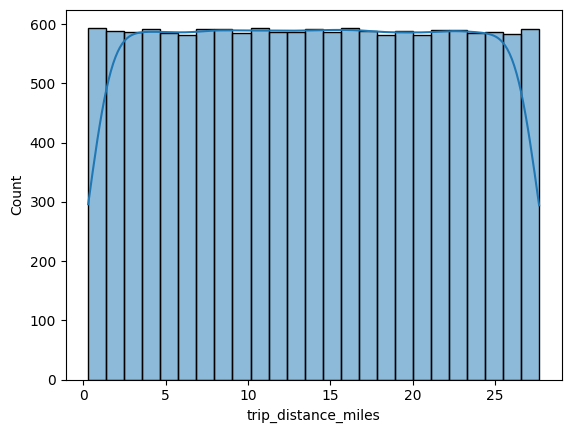

In [ ]:
#histogram
sns.histplot(train['trip_distance_miles'],kde = True)

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'tolls_amount',
 'tip_amount',
 'fare_estimate',
 'trip_distance_miles']

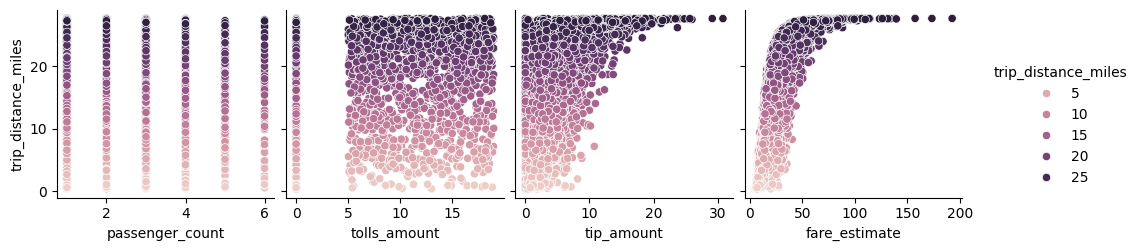

In [ ]:
sns.pairplot(data=train,x_vars=['passenger_count','tolls_amount', 'tip_amount', 'fare_estimate'], y_vars=["trip_distance_miles"], hue="trip_distance_miles")


In [ ]:
def findTravelingTime(df):
  # If times are present, include them in format, otherwise use date-only format
  formatted_startDt = pd.to_datetime(df['pickup_datetime'], format="%m/%d/%y %H:%M", errors='coerce')
  formatted_endDt   = pd.to_datetime(df['dropoff_datetime'],   format="%m/%d/%y %H:%M", errors='coerce')

  # Difference in minutes:
  time_diff = (formatted_endDt - formatted_startDt).dt.total_seconds() / 60.0
  return time_diff


In [ ]:
def findCongestionRatio(orig_dist, travel_dist):
  return (travel_dist-orig_dist)/orig_dist

In [ ]:
# feature engineering for both train and test

for df in [train, test]:
  df['traveling_time_mins'] = findTravelingTime(df)
  df['geographical_distance'] = df.apply(lambda row: haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), axis=1)




In [ ]:
df.head(6)

,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,traffic_congestion_level,pickup_borough,dropoff_borough,tolls_amount,tip_amount,fare_estimate,trip_distance_miles,traveling_time_mins,geographical_distance
0,1/28/24 17:44,1/28/24 18:03,40.855567,-74.244521,40.891126,-74.208418,2,low,Bronx,Bronx,0.0,6.67,26.69,NaN,19.0,4.984844
1,11/27/24 11:37,11/27/24 11:45,40.895791,-74.190683,40.875638,-74.196187,1,medium,Bronx,Bronx,0.0,2.78,11.21,NaN,8.0,2.288181
2,5/11/24 2:48,5/11/24 3:04,40.820683,-74.163929,40.867325,-74.221284,1,low,Bronx,Bronx,0.0,4.07,27.73,NaN,16.0,7.083432
3,3/11/24 18:05,3/11/24 18:33,40.685081,-73.774795,40.640616,-73.744560,1,high,Brooklyn,Brooklyn,0.0,1.93,32.63,NaN,28.0,5.563247
4,9/3/24 1:13,9/3/24 1:26,40.645333,-73.990859,40.607227,-74.009520,4,low,Other,Other,0.0,6.12,20.05,NaN,13.0,4.520403
5,5/1/24 11:21,5/1/24 11:30,40.648275,-74.130405,40.666318,-74.163397,3,low,Staten Island,Other,5.2,3.67,21.05,NaN,9.0,3.430810


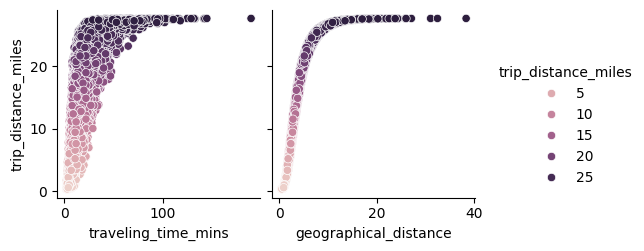

In [ ]:
sns.pairplot(data=train,x_vars=['traveling_time_mins','geographical_distance'], y_vars=["trip_distance_miles"], hue="trip_distance_miles")

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['pickup_latitude',
 'pickup_longitude',
 'dropoff_latitude',
 'dropoff_longitude',
 'passenger_count',
 'tolls_amount',
 'tip_amount',
 'fare_estimate',
 'trip_distance_miles',
 'traveling_time_mins',
 'geographical_distance']

In [ ]:
train[num_cols].corr()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,tolls_amount,tip_amount,fare_estimate,trip_distance_miles,traveling_time_mins,geographical_distance
pickup_latitude,1.000000,-0.007638,0.960485,-0.003322,-0.005840,0.029540,-0.003665,0.005469,-0.006858,-0.002424,-0.004141
pickup_longitude,-0.007638,1.000000,-0.010806,0.968296,0.005260,0.012640,0.006725,-0.000082,-0.006374,-0.002941,-0.004984
dropoff_latitude,0.960485,-0.010806,1.000000,-0.008057,-0.005202,0.029108,0.005242,0.012508,-0.001130,0.003373,0.005598
dropoff_longitude,-0.003322,0.968296,-0.008057,1.000000,0.003920,0.007465,0.005642,-0.002851,-0.007142,-0.004437,-0.006924
passenger_count,-0.005840,0.005260,-0.005202,0.003920,1.000000,-0.021522,-0.010351,-0.011415,0.003636,-0.004526,-0.008724
tolls_amount,0.029540,0.012640,0.029108,0.007465,-0.021522,1.000000,0.328884,0.436526,0.171106,0.164926,0.191272
tip_amount,-0.003665,0.006725,0.005242,0.005642,-0.010351,0.328884,1.000000,0.749582,0.598798,0.698371,0.683072
fare_estimate,0.005469,-0.000082,0.012508,-0.002851,-0.011415,0.436526,0.749582,1.000000,0.794198,0.933403,0.911091
trip_distance_miles,-0.006858,-0.006374,-0.001130,-0.007142,0.003636,0.171106,0.598798,0.794198,1.000000,0.737503,0.860327
traveling_time_mins,-0.002424,-0.002941,0.003373,-0.004437,-0.004526,0.164926,0.698371,0.933403,0.737503,1.000000,0.844966


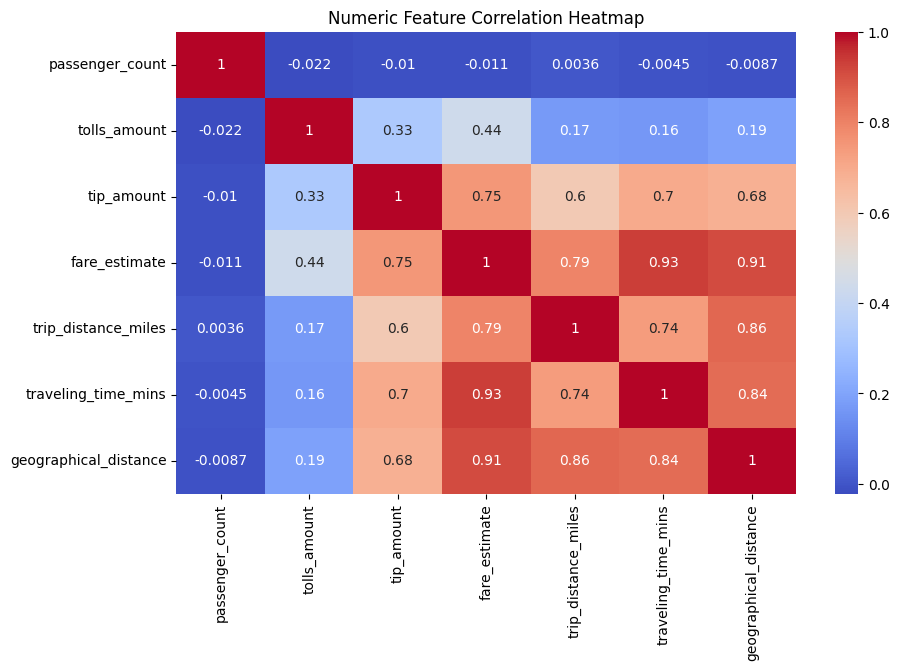

In [ ]:
# Correlation heatmap (numeric features)
selected_num_columns = ['passenger_count', 'tolls_amount', 'tip_amount', 'fare_estimate', 'trip_distance_miles', 'traveling_time_mins','geographical_distance']
df_selected = train[selected_num_columns]
correlation_matrix = df_selected.corr()

plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [ ]:
cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["trip_distance_miles"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with House Price (lower p = stronger association):")
display(chi_df)

Chi-Square association with House Price (lower p = stronger association):


,Feature,Chi2,p_value
4,dropoff_borough,11.894155,0.454217
1,dropoff_datetime,43563.667929,0.494142
0,pickup_datetime,43399.667655,0.545482
2,traffic_congestion_level,4.399122,0.622831
3,pickup_borough,7.608831,0.814904


In [ ]:
# Feature selection
target = "trip_distance_miles"
# , 'dropoff_borough','traffic_congestion_level', 'pickup_borough' cat_cols

features = ['passenger_count', 'tolls_amount', 'tip_amount', 'fare_estimate',  'traveling_time_mins','geographical_distance']

X = train[features]
y = train[target]

X_test = test[features]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [ ]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("categorical", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())]) #Solves

In [ ]:
lin_pipe.fit(X,y) #Gradient descent is happening here..!
y_pred = lin_pipe.predict(X)

In [ ]:
r2 = r2_score(y,y_pred)
rmse = np.sqrt(mean_squared_error(y,y_pred))

In [ ]:
print(f"Linear Regression without Polynomial r2 --- {r2} --- {rmse}")


Feature engineering for both train and test with the respective dataset r2 --- 0.7418566927117982 --- 4.013803443367568


In [ ]:
test.isna().sum()


,0
pickup_datetime,0
dropoff_datetime,0
pickup_latitude,0
pickup_longitude,0
dropoff_latitude,0
dropoff_longitude,0
passenger_count,0
traffic_congestion_level,0
pickup_borough,0
dropoff_borough,0


In [ ]:
preds = lin_pipe.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({
                           'trip_distance_miles':preds
                           })

submission.to_csv("Submission_TaxiTripDistancePrediction_LR.csv",index=False)

Data Split

In [ ]:
#Splitting Train and Test Data
X_train, y_train, X_val, y_val = train_test_split(X, y, test_size = 0.2, random_state = 30)


In [ ]:

X_train.shape, y_train.shape, X_val.shape,  y_val.shape

((11759, 6), (2940, 6), (11759,), (2940,))

In [ ]:
# Numeric pipeline: scaling + polynomial expansion
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False))
])
# Categorical pipeline: one-hot encoding
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
numeric_features = ['passenger_count', 'tolls_amount', 'tip_amount', 'fare_estimate',  'traveling_time_mins','geographical_distance']
category_features = ['dropoff_borough', 'traffic_congestion_level', 'pickup_borough']
# CATEGORY FEATURES ARE NOT ADDED AS THEY DONT HAVE ANY ASSOCIATION
# Combine both ("cat", categorical_transformer, category_features)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)


    ]
)


In [ ]:
#Train split
poly_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

# Fit
poly_model.fit(X_train, X_val)

# Predict
y_pred = poly_model.predict(y_train)

In [ ]:
r2 = r2_score(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))

In [ ]:
print (f"2 Degree Polynomial Linear Regression without Regularization for train: R2 --- {r2} RMSE--- {rmse}")

2 Degree Polynomial Linear Regression without Regularization for train: R2 --- 0.8455269293362333 RMSE--- 3.1393632145803743


In [ ]:
preds = poly_model.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({
                           'trip_distance_miles':preds
                           })

submission.to_csv("Submission_TaxiTripDistancePrediction_Polynomial.csv",index=False)

In [ ]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

In [ ]:
# -----------------------------------
# Ridge Regression Model Pipeline
# -----------------------------------
ridge_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("ridge", Ridge(alpha=0.1))    # you can tune alpha
])

In [ ]:
ridge_model.fit(X_train, X_val)



Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['passenger_count',
                                                   'tolls_amount', 'tip_amount',
                                                   'fare_estimate',
                                                   'traveling_time_mins',
                                                   'geographical_distance'])])),
                ('ridge', Ridge(alpha=0.1))])

In [ ]:

y_pred = poly_model.predict(y_train)
r2 = r2_score(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print (f"1 Degree Polynomial Ridge Regression: R2 --- {r2} RMSE--- {rmse}")

1 Degree Polynomial Ridge Regression: R2 --- 0.8306843261695656 RMSE--- 3.2867279419454594


In [ ]:
preds = ridge_model.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({
                           'trip_distance_miles':preds
                           })

submission.to_csv("Submission_TaxiTripDistancePrediction_Ridge.csv",index=False)

In [ ]:


ridge_coef_ = ridge_model.named_steps['ridge'].coef_

In [ ]:
ridge_coef_

array([ 1.20828442e-02, -1.24703665e+00,  1.45648339e-01,  3.83777437e+00,
       -1.85770454e+00,  8.20659845e+00,  7.83380632e-03, -1.86553246e-02,
       -4.21618394e-02,  1.79418303e-01, -1.05380002e-01, -1.00773662e-01,
       -4.57826142e-02,  3.00759022e-01,  5.69475160e-01,  3.13275189e-03,
       -3.76912888e-01, -7.77021009e-02, -1.13871456e+00,  5.75262439e-01,
        4.75717257e-01, -7.28467727e-01, -1.98566780e-01,  1.27829307e+00,
        1.73496421e-01,  1.13456204e-02, -1.97719379e+00])

In [ ]:
########### LASSO Regression ############
lasso_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("lasso", Lasso(alpha=0.1, max_iter=500))
])

In [ ]:
lasso_model.fit(X_train, X_val)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['passenger_count',
                                                   'tolls_amount', 'tip_amount',
                                                   'fare_estimate',
                                                   'traveling_time_mins',
                                                   'geographical_distance'])])),
                ('lasso', Lasso(alpha=0.1, max_iter=500))])

In [ ]:
y_pred = lasso_model.predict(y_train)
r2 = r2_score(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print (f"1 Degree Polynomial Lasso Regression: R2 --- {r2} RMSE--- {rmse}")

1 Degree Polynomial Lasso Regression: R2 --- 0.836462157466967 RMSE--- 3.230162026601379


In [ ]:
preds = lasso_model.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({
                           'trip_distance_miles':preds
                           })

submission.to_csv("Submission_TaxiTripDistancePrediction_Lasso.csv",index=False)

In [ ]:
############## ELASTIC NET Regression ##########
elastic_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("elastic", ElasticNet(alpha=0.1, l1_ratio=0.5, max_iter=5000))
])

In [ ]:
elastic_model.fit(X_train, X_val)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['passenger_count',
                                                   'tolls_amount', 'tip_amount',
                                                   'fare_estimate',
                                                   'traveling_time_mins',
                                                   'geographical_distance'])])),
                ('elastic', ElasticNet(alpha=0.1, max_iter=5000))])

In [ ]:

# Predict
y_pred = elastic_model.predict(y_train)
r2 = r2_score(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
print (f"1 Degree Polynomial Elastic Net Regression: R2 --- {r2} RMSE--- {rmse}")

1 Degree Polynomial Elastic Net Regression: R2 --- 0.8455269293362333 RMSE--- 3.1393632145803743


In [1]:
preds = elastic_model.predict(X_test)

preds = np.clip(preds,0,None)

submission = pd.DataFrame({
                           'trip_distance_miles':preds
                           })

submission.to_csv("Submission_TaxiTripDistancePrediction_ElasticNet.csv",index=False)

NameError: name 'elastic_model' is not defined